# Determining cars prices

In [1]:
from sklearn.dummy import DummyRegressor
import pandas as pd
from math import sqrt
from lightgbm import LGBMRegressor
import lightgbm
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split as tts, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import time
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Getting the data

In [2]:
pth1 = '/datasets/autos.csv'
pth2 = r'C:\Users\exeve\Downloads\autos.csv'

try:
    if os.path.exists(pth1):
        data = pd.read_csv(pth1)
    elif os.path.exists(pth2):
        data = pd.read_csv(pth2)
except:
    print('Something went wrong')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Removing unnecessary columns

In [4]:
data = data.drop(['DateCrawled', 'NumberOfPictures', 'PostalCode', 'DateCreated', 'LastSeen', 'RegistrationMonth'], axis = 1)

### Gaps

In [5]:
data.isna().sum()

Price                   0
VehicleType         37490
RegistrationYear        0
Gearbox             19833
Power                   0
Model               19705
Kilometer               0
FuelType            32895
Brand                   0
Repaired            71154
dtype: int64

In [6]:
# filling the gaps in cathegorical features with  -unknown-

data['VehicleType'] = data['VehicleType'].fillna('unknown')
data['Gearbox'] = data['Gearbox'].fillna('unknown')
data['Model'] = data['Model'].fillna('unknown')
data['FuelType'] = data['FuelType'].fillna('unknown')
data['Repaired'] = data['Repaired'].fillna('unknown')

In [7]:
data.columns = data.columns.str.lower()

### Analysis of data['registrationyear']

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64

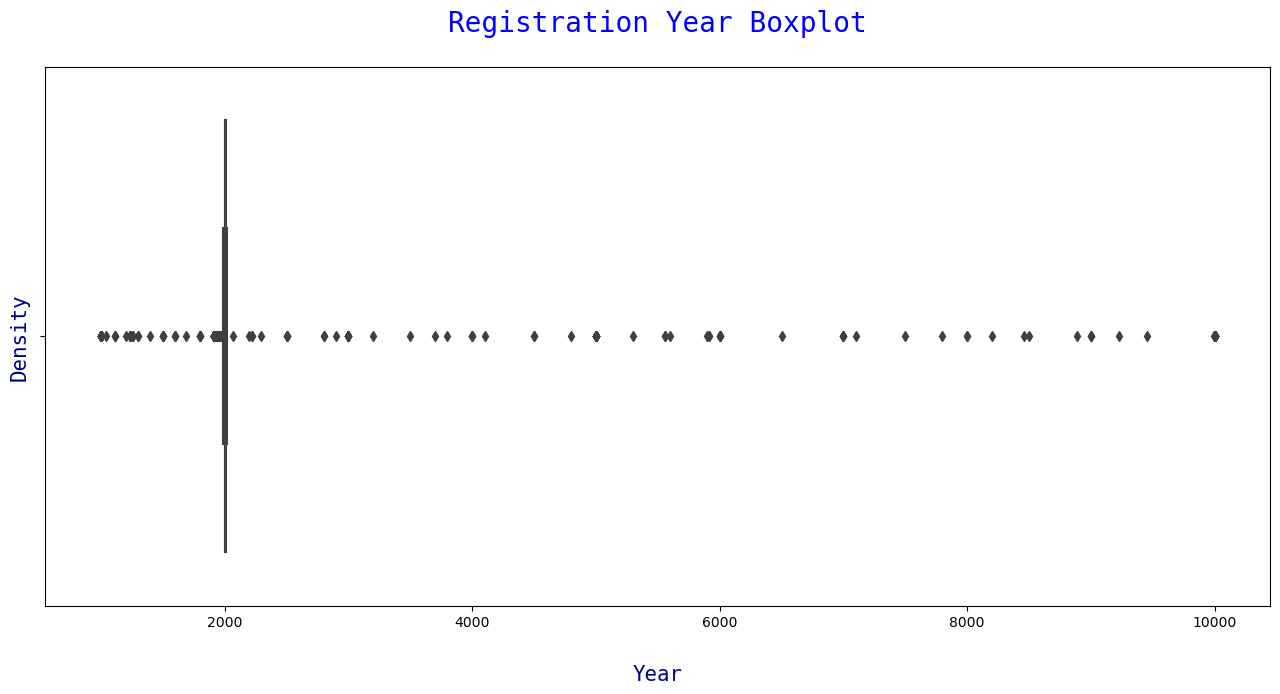

In [8]:
display(data['registrationyear'].describe())

plt.figure(figsize=(14,7))

sns.boxplot(data = data, x ='registrationyear')

font_title = {'size' : 20, 'color': 'blue', 'family' : 'monospace'}
font_label = {'size' : 15, 'color' : 'darkblue', 'family' : 'monospace'}

plt.title('Registration Year Boxplot', fontdict = font_title, y = 1.05)
plt.xlabel('Year', fontdict = font_label, labelpad = 25)
plt.ylabel('Density', fontdict = font_label)

plt.subplots_adjust(right = 1)

plt.show()

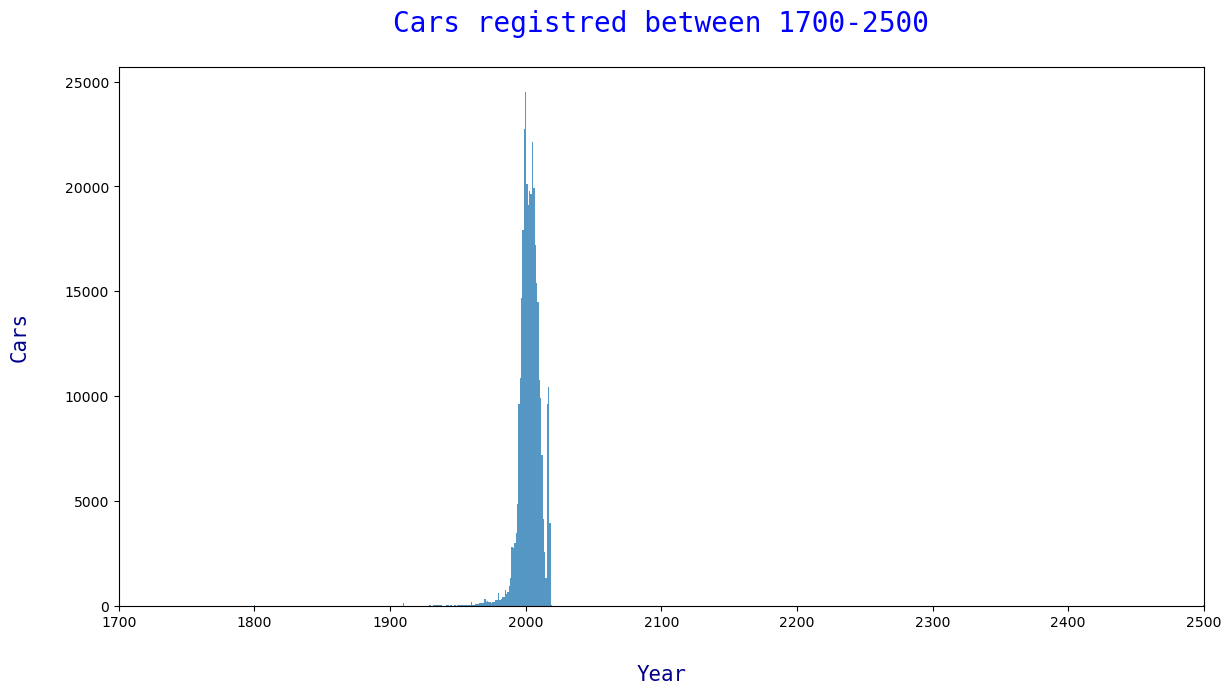

In [9]:

plt.figure(figsize=(14,7))
sns.histplot(data = data, x = 'registrationyear', common_norm = True, discrete = True)
plt.xlim(1700,2500)
plt.xlabel('Year', fontdict = font_label, labelpad = 25)
plt.ylabel('Cars', fontdict = font_label, labelpad = 25)
plt.title('Cars registred between 1700-2500', fontdict = font_title, y = 1.05)
plt.show()


In [10]:
# let's shrink the three sigmas interval

sigma_year = data['registrationyear'].std()
upper_limit_year = int(data['registrationyear'].mean() + 3 * sigma_year)
lower_limit_year = int(data['registrationyear'].mean() - 3 * sigma_year)
print(lower_limit_year,'-', upper_limit_year)

1733 - 2274


Cars were invented in 1886. Let's choose the interval 1886 - 2016 (year of data release)

In [11]:
data = data.query('registrationyear >= 1886 and registrationyear <= 2016')


In [12]:
sigma_year = data['registrationyear'].std()
upper_limit_year = int(data['registrationyear'].mean() + 3 * sigma_year)
lower_limit_year = int(data['registrationyear'].mean() - 3 * sigma_year)
print(lower_limit_year,'-', upper_limit_year)

1981 - 2023


Now the three-sigma interval is more adequate.

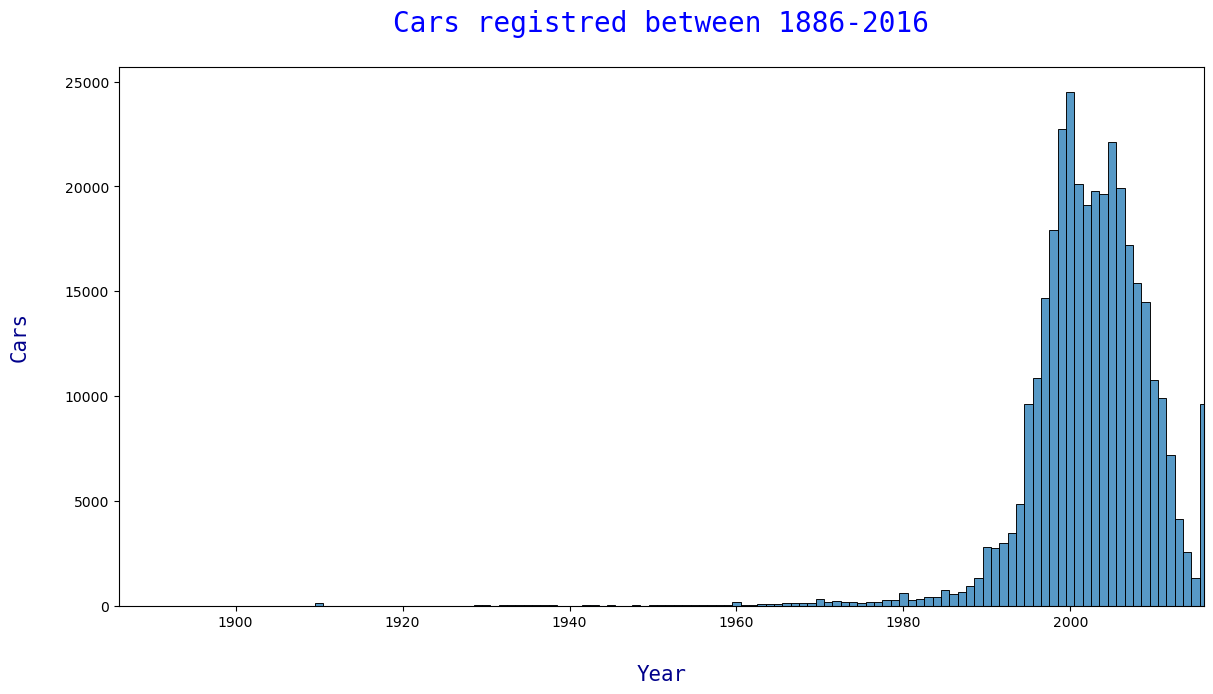

In [13]:

plt.figure(figsize=(14,7))
sns.histplot(data = data, x = 'registrationyear', common_norm = True, discrete = True)
plt.xlim(1886,2016)
plt.xlabel('Year', fontdict = font_label, labelpad = 25)
plt.ylabel('Cars', fontdict = font_label, labelpad = 25)
plt.title('Cars registred between 1886-2016', fontdict = font_title, y = 1.05)
plt.show()


In [14]:
data = data.query('registrationyear >= 1981 and registrationyear <= 2016')

### Analysis of data['power']

count    335799.000000
mean        111.476487
std         185.634013
min           0.000000
25%          70.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

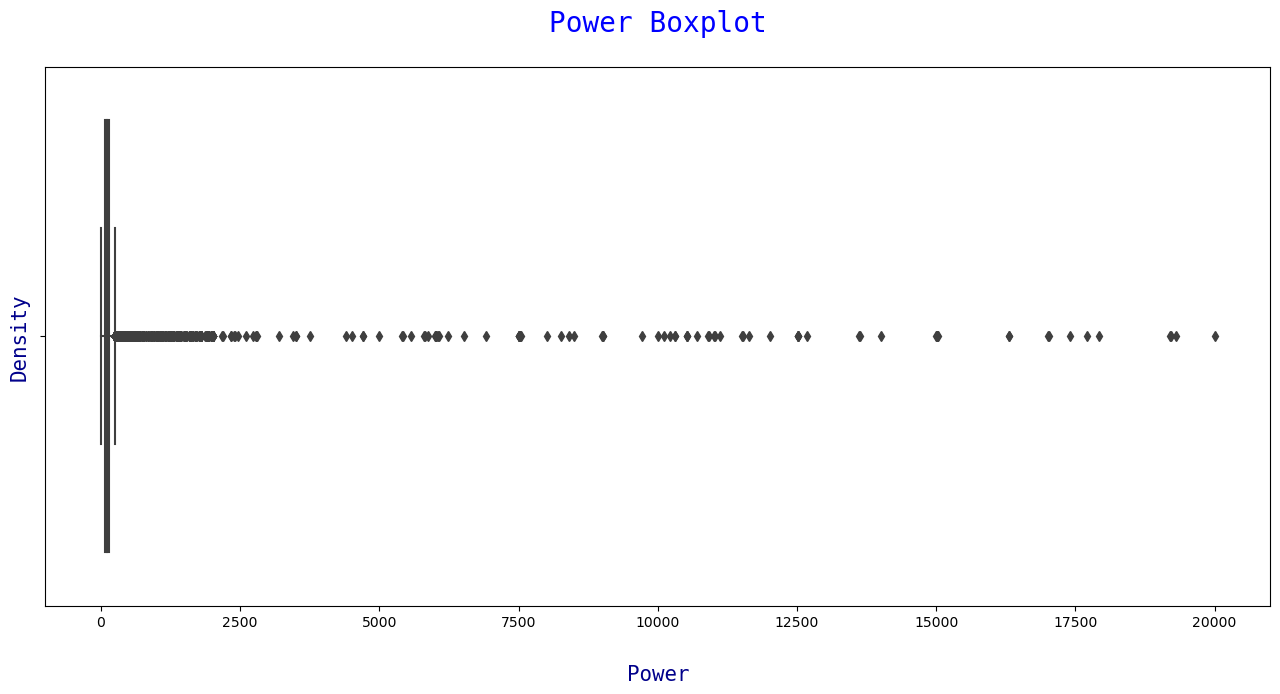

In [15]:
display(data['power'].describe())

plt.figure(figsize=(14,7))

sns.boxplot(data = data, x = 'power')

font_title = {'size' : 20, 'color': 'blue', 'family' : 'monospace'}
font_label = {'size' : 15, 'color' : 'darkblue', 'family' : 'monospace'}

plt.title('Power Boxplot', fontdict = font_title, y = 1.05)
plt.xlabel('Power', fontdict = font_label, labelpad = 25)
plt.ylabel('Density', fontdict = font_label)

plt.subplots_adjust(right = 1)

plt.show()

In [16]:
# let's remove objects where power is less than 0

data = data.query('power > 0')

In [17]:
#let's look at the range of the most probable values

sigma_power = data['power'].std()
upper_limit_power = int(data['power'].mean() + 3 * sigma_power)
lower_limit_power = int(data['power'].mean() - 3 * sigma_power)
print(lower_limit_power,'-', upper_limit_power)

-451 - 700


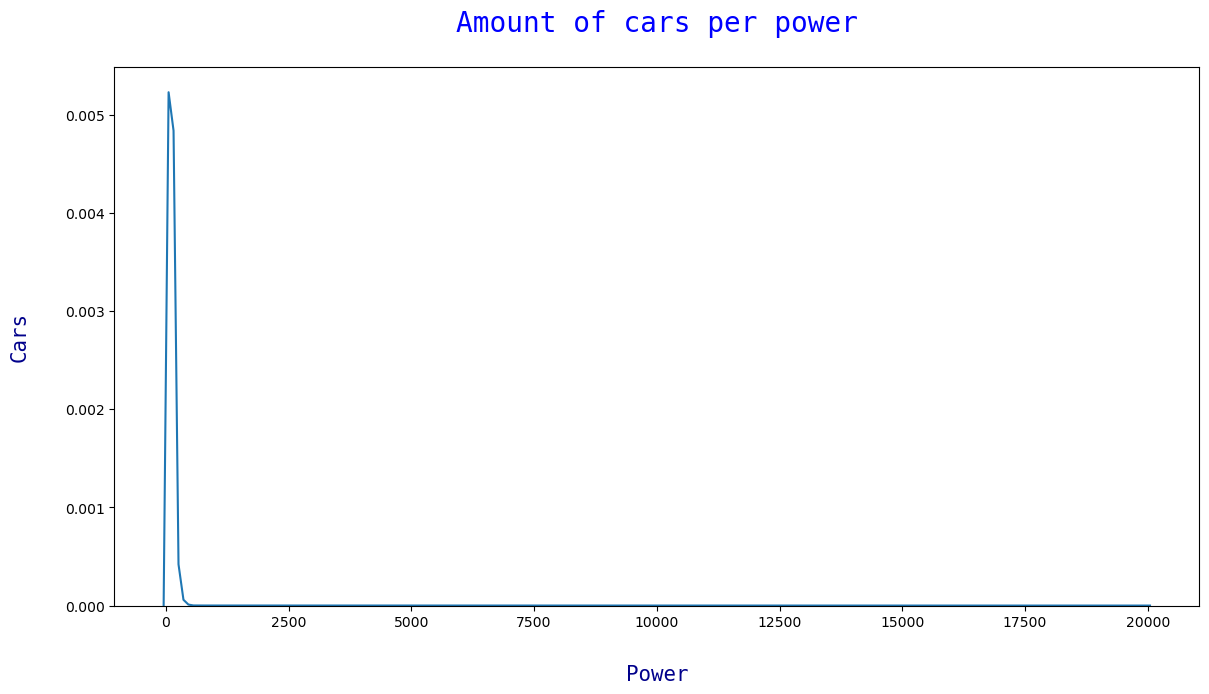

In [18]:
plt.figure(figsize=(14,7))
sns.kdeplot(data = data, x = 'power')
plt.xlabel('Power', fontdict = font_label, labelpad = 25)
plt.ylabel('Cars', fontdict = font_label, labelpad = 25)
plt.title('Amount of cars per power', fontdict = font_title, y = 1.05)
plt.show()

Let's take the SmartForTwo (45 HP) as the minimum threshold.

In [19]:
data = data.query('power >= 45 and power <= 704')

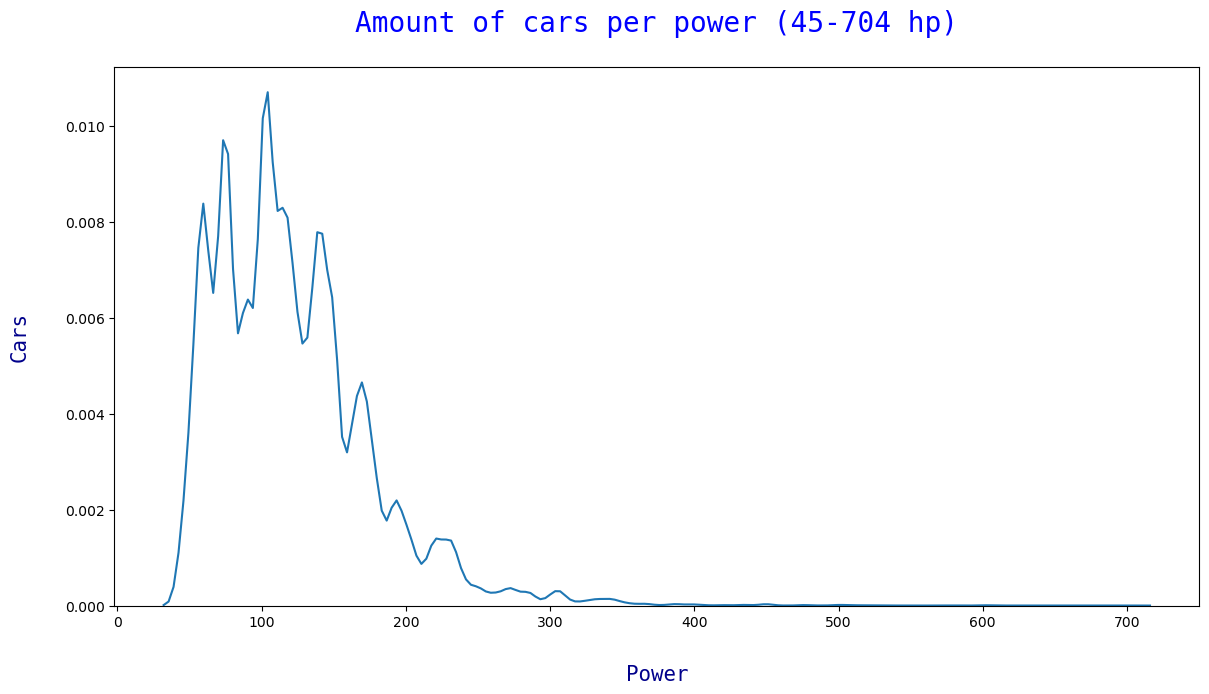

In [20]:
plt.figure(figsize=(14,7))
sns.kdeplot(data = data, x = 'power')

plt.xlabel('Power', fontdict = font_label, labelpad = 25)
plt.ylabel('Cars', fontdict = font_label, labelpad = 25)
plt.title('Amount of cars per power (45-704 hp)', fontdict = font_title, y = 1.05)
plt.show()

The graph shows that there are practically no cars with a power of more than 300 hp. Let's look at the three-sigma intervals again and shorten the interval.

In [21]:
sigma_power = data['power'].std()
upper_limit_power = int(data['power'].mean() + 3 * sigma_power)
lower_limit_power = int(data['power'].mean() - 3 * sigma_power)
print(lower_limit_power,'-', upper_limit_power)

-39 - 282


In [22]:
data = data.query('power >= 45 and power <= 282')

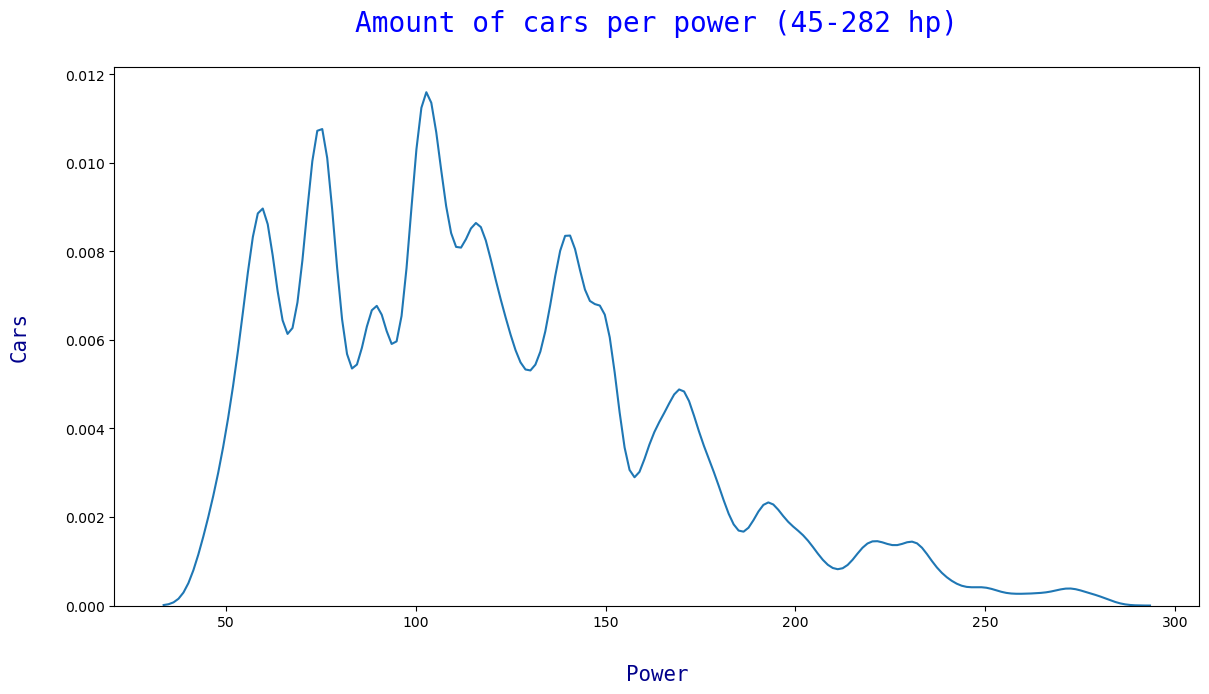

In [23]:
plt.figure(figsize=(14,7))
sns.kdeplot(data = data, x = 'power')

plt.xlabel('Power', fontdict = font_label, labelpad = 25)
plt.ylabel('Cars', fontdict = font_label, labelpad = 25)
plt.title('Amount of cars per power (45-282 hp)', fontdict = font_title, y = 1.05)
plt.show()

### data['vehicletype']

In [24]:
data['vehicletype'].value_counts()

sedan          81872
small          69816
wagon          59693
bus            26368
convertible    18210
coupe          13756
unknown        11616
suv            10348
other           2402
Name: vehicletype, dtype: int64

### data['gearbox']

In [25]:
data['gearbox'].value_counts()

manual     233296
auto        55386
unknown      5399
Name: gearbox, dtype: int64

### data['model']

In [26]:
data['model'].value_counts()

golf          25232
other         18809
3er           17543
unknown       10896
polo          10855
              ...  
samara            5
911               5
rangerover        2
601               1
serie_2           1
Name: model, Length: 248, dtype: int64

### data['kilometer']

count    294081.000000
mean     128717.853245
std       36475.793225
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

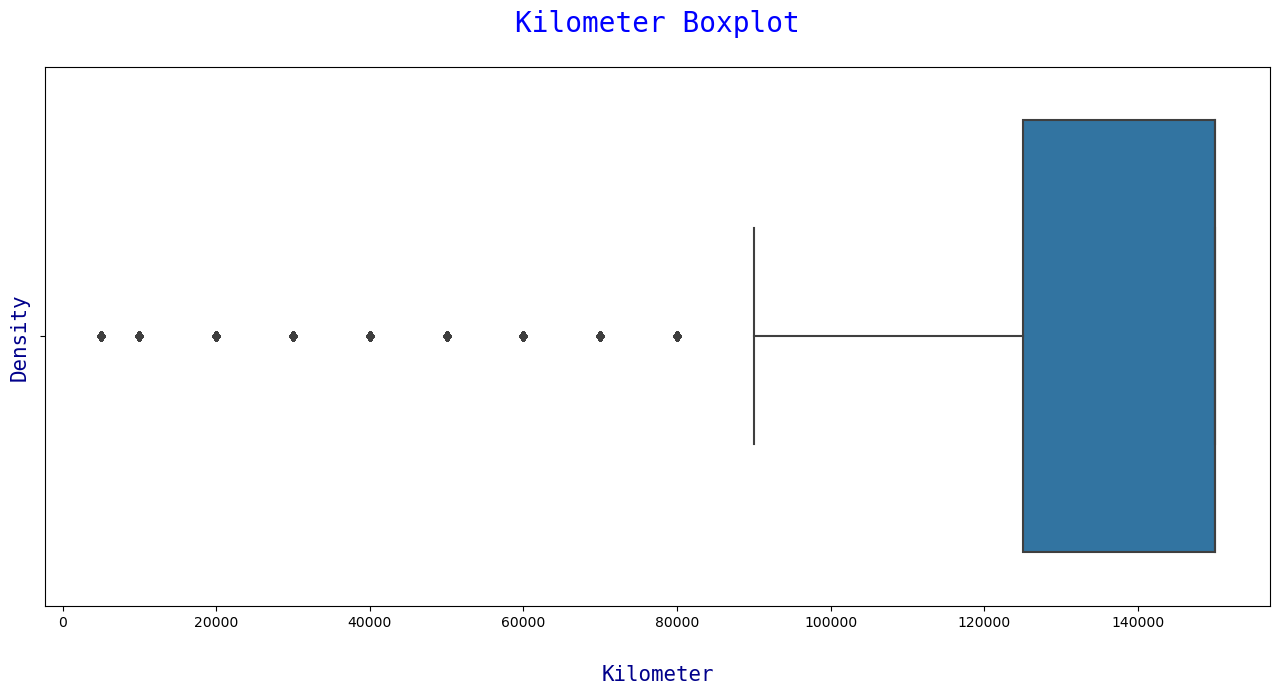

In [27]:
display(data['kilometer'].describe())

plt.figure(figsize=(14,7))

sns.boxplot(data = data, x = 'kilometer')

font_title = {'size' : 20, 'color': 'blue', 'family' : 'monospace'}
font_label = {'size' : 15, 'color' : 'darkblue', 'family' : 'monospace'}

plt.title('Kilometer Boxplot', fontdict = font_title, y = 1.05)
plt.xlabel('Kilometer', fontdict = font_label, labelpad = 25)
plt.ylabel('Density', fontdict = font_label)

plt.subplots_adjust(right = 1)

plt.show()

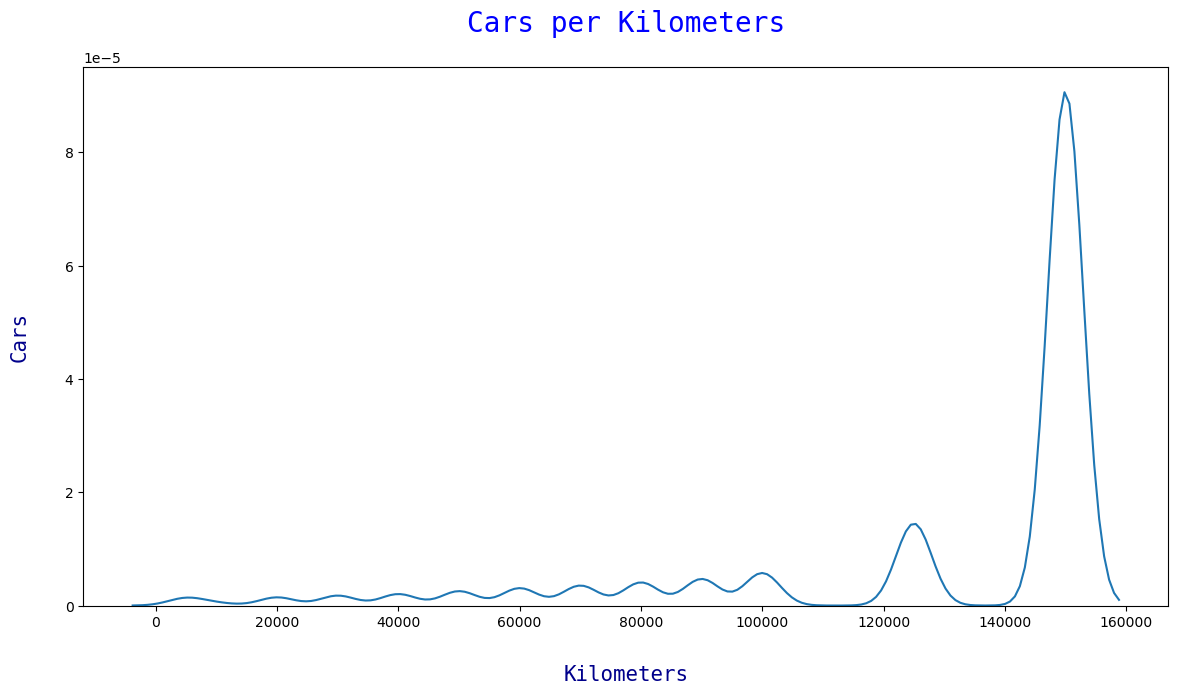

In [28]:
plt.figure(figsize=(14,7))
sns.kdeplot(data = data, x = 'kilometer')

plt.xlabel('Kilometers', fontdict = font_label, labelpad = 25)
plt.ylabel('Cars', fontdict = font_label, labelpad = 25)
plt.title('Cars per Kilometers', fontdict = font_title, y = 1.05)
plt.show()

In [29]:
data = data.query('kilometer >= 90000')

### data['fueltype']

In [30]:
data['fueltype'].value_counts()

petrol      151365
gasoline     79855
unknown      14549
lpg           4213
cng            419
hybrid          90
other           45
electric        14
Name: fueltype, dtype: int64

In [31]:
# petrol and gasoline is the same, so let's leave "petrol" only

data['fueltype'] = data['fueltype'].replace('gasoline', 'petrol')

### data['brand']

In [32]:
data['brand'].value_counts()

volkswagen        56286
bmw               29242
opel              28417
mercedes_benz     24022
audi              23117
ford              17178
renault           12007
peugeot            7801
fiat               5701
seat               4673
mazda              4067
skoda              3688
citroen            3352
nissan             3193
toyota             3093
volvo              2695
smart              2270
mitsubishi         2162
hyundai            2029
honda              2021
mini               1760
alfa_romeo         1748
kia                1502
suzuki             1337
chrysler           1066
sonstige_autos      835
chevrolet           832
subaru              559
jeep                495
saab                451
daihatsu            447
land_rover          426
dacia               379
daewoo              352
rover               345
porsche             322
lancia              320
jaguar              317
lada                 40
trabant               3
Name: brand, dtype: int64

### data['repaired']

In [33]:
data['repaired'].value_counts()

no         183773
unknown     39502
yes         27275
Name: repaired, dtype: int64

### Target Analysis

count    250550.000000
mean       3983.468888
std        3980.654176
min           0.000000
25%        1100.000000
50%        2500.000000
75%        5500.000000
max       20000.000000
Name: price, dtype: float64

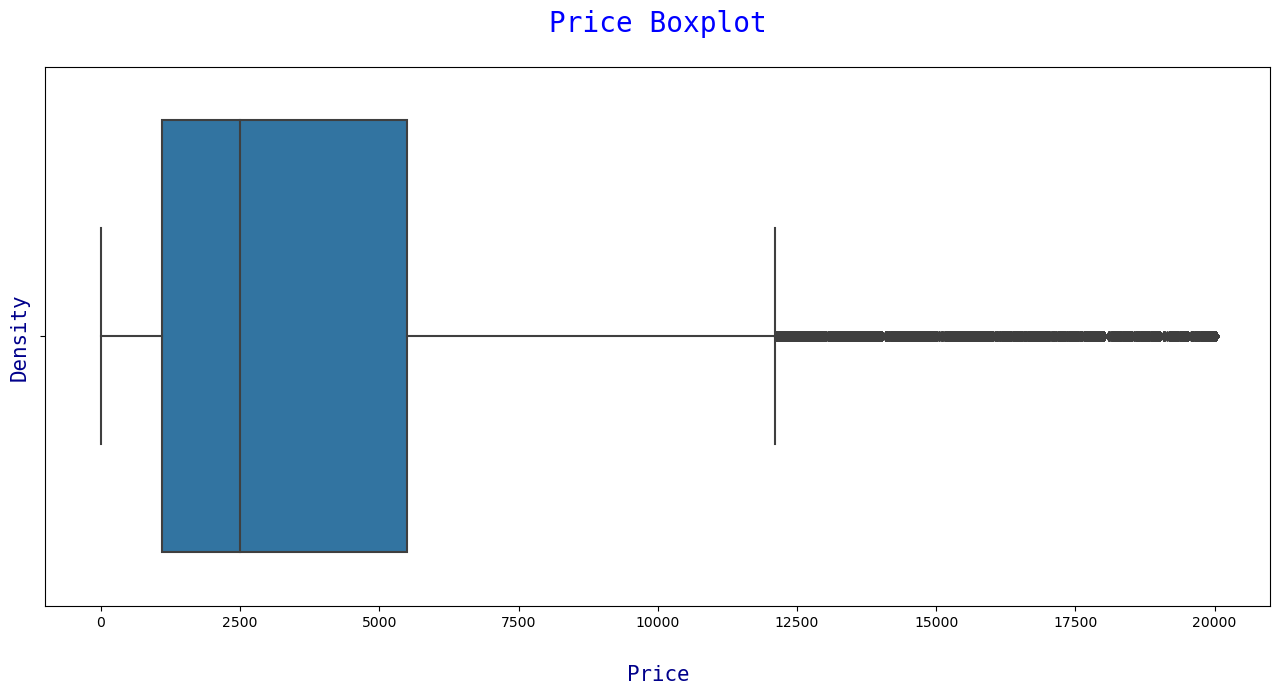

In [34]:
display(data['price'].describe())

plt.figure(figsize=(14,7))

sns.boxplot(data = data, x = 'price')

font_title = {'size' : 20, 'color': 'blue', 'family' : 'monospace'}
font_label = {'size' : 15, 'color' : 'darkblue', 'family' : 'monospace'}

plt.title('Price Boxplot', fontdict = font_title, y = 1.05)
plt.xlabel('Price', fontdict = font_label, labelpad = 25)
plt.ylabel('Density', fontdict = font_label)

plt.subplots_adjust(right = 1)

plt.show()



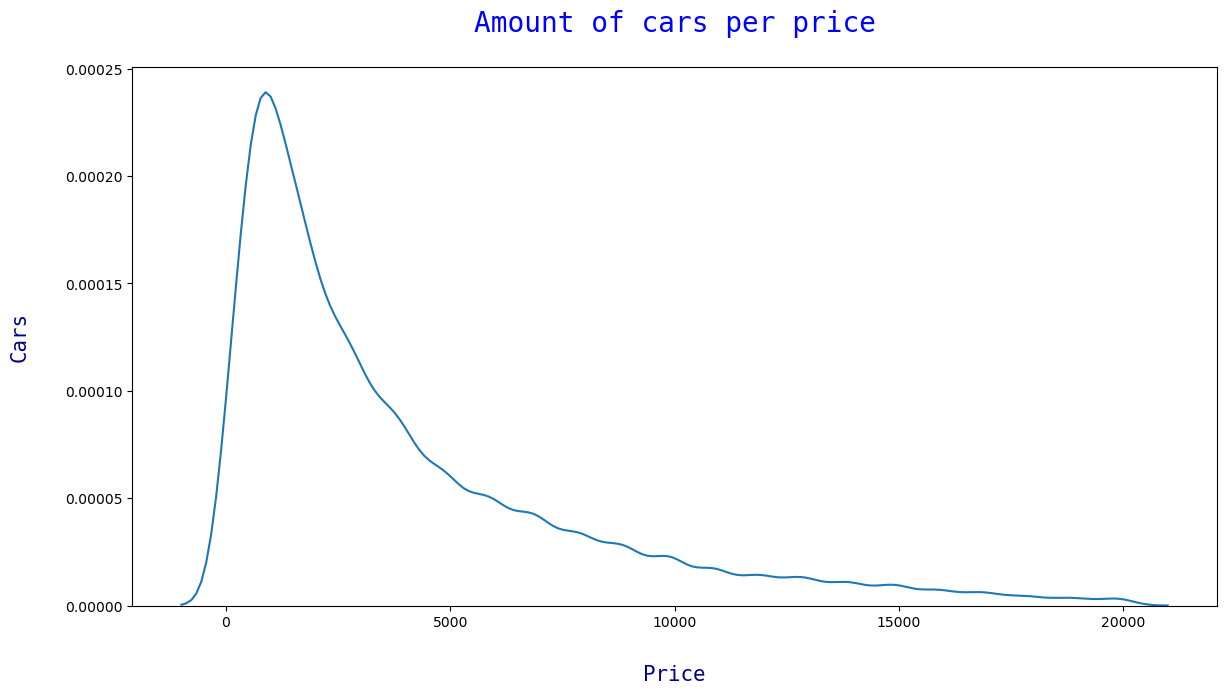

In [35]:
plt.figure(figsize=(14,7))
sns.kdeplot(data = data, x = 'price')


plt.xlabel('Price', fontdict = font_label, labelpad = 25)
plt.ylabel('Cars', fontdict = font_label, labelpad = 25)
plt.title('Amount of cars per price', fontdict = font_title, y = 1.05)
plt.show()


In [36]:
data = data.query('price > 400 and price <= 15000')

### Duplicates

In [37]:
data.duplicated().sum()

33544

In [38]:
data = data.drop_duplicates()

In [39]:
data = data.reset_index(drop=True)

## Models training

### Getting training and testing samples

In [40]:
features = data.drop('price', axis = 1)
target = data['price']

features_train, features_test, target_train, target_test = tts(features, target, test_size = 0.10, random_state = 12345)


### Converting categorical features into binary ones

In [41]:
to_encode = list(data.drop(['price', 'registrationyear', 'power', 'kilometer'], axis = 1).columns)


ohe = OneHotEncoder(drop = 'first', handle_unknown = 'infrequent_if_exist')

In [42]:
ohe.fit(features_train[to_encode])

feature_names = ohe.get_feature_names_out()



#encoding features_train

features_train_ohe = features_train

features_array = ohe.transform(features_train[to_encode]).toarray()
ohe_features = pd.DataFrame(features_array, columns = feature_names)
features_train_ohe = features_train_ohe.drop(to_encode, axis = 1)

features_train_ohe = features_train_ohe.reset_index(drop=True)
ohe_features = ohe_features.reset_index(drop=True)

features_train_ohe = features_train_ohe.join(ohe_features, how = 'outer')
display(features_train_ohe.head())


# encoding features_test

features_test_ohe = features_test

features_array_t = ohe.transform(features_test[to_encode]).toarray()
ohe_features_t = pd.DataFrame(features_array_t, columns = feature_names)
features_test_ohe = features_test_ohe.drop(to_encode, axis = 1)

features_test_ohe = features_test_ohe.reset_index(drop=True)
ohe_features_t = ohe_features_t.reset_index(drop=True)

features_test_ohe = features_test_ohe.join(ohe_features_t, how = 'outer')
display(features_test_ohe.head())


,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_unknown,vehicletype_wagon,gearbox_manual,gearbox_unknown,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_unknown,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fueltype_electric,fueltype_hybrid,fueltype_lpg,fueltype_other,fueltype_petrol,fueltype_unknown,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
0,1999,58,100000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_unknown,vehicletype_wagon,gearbox_manual,gearbox_unknown,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_unknown,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fueltype_electric,fueltype_hybrid,fueltype_lpg,fueltype_other,fueltype_petrol,fueltype_unknown,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
0,2001,241,150000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### Scaling

In [43]:
for_scaling = ['registrationyear','power','kilometer']

scaler = StandardScaler()

scaler.fit(features_train_ohe[for_scaling])

scaled_feature_names = scaler.get_feature_names_out()

features_train_scaled = features_train_ohe
features_test_scaled = features_test_ohe

features_train_scaled[for_scaling] = pd.DataFrame(scaler.transform(features_train_ohe[for_scaling]), columns = scaled_feature_names)

features_test_scaled[for_scaling] = pd.DataFrame(scaler.transform(features_test_ohe[for_scaling]), columns = scaled_feature_names)

In [44]:
display(features_train_scaled.head())
display(features_test_scaled.head())

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_unknown,vehicletype_wagon,gearbox_manual,gearbox_unknown,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_unknown,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fueltype_electric,fueltype_hybrid,fueltype_lpg,fueltype_other,fueltype_petrol,fueltype_unknown,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
0,-0.629513,-1.374071,-2.433596,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

,registrationyear,power,kilometer,vehicletype_convertible,vehicletype_coupe,vehicletype_other,vehicletype_sedan,vehicletype_small,vehicletype_suv,vehicletype_unknown,vehicletype_wagon,gearbox_manual,gearbox_unknown,model_145,model_147,model_156,model_159,model_1_reihe,model_1er,model_200,model_2_reihe,model_300c,model_3_reihe,model_3er,model_4_reihe,model_500,model_5_reihe,model_5er,model_6_reihe,model_6er,model_7er,model_80,model_850,model_90,model_900,model_9000,model_911,model_a1,model_a2,model_a3,model_a4,model_a5,model_a6,model_a8,model_a_klasse,model_accord,model_agila,model_alhambra,model_almera,model_altea,model_amarok,model_antara,model_arosa,model_astra,model_auris,model_avensis,model_aveo,model_aygo,model_b_klasse,model_b_max,model_beetle,model_berlingo,model_bora,model_boxster,model_bravo,model_c1,model_c2,model_c3,model_c4,model_c5,model_c_klasse,model_c_max,model_c_reihe,model_caddy,model_calibra,model_captiva,model_carisma,model_carnival,model_cayenne,model_cc,model_ceed,model_charade,model_cherokee,model_civic,model_cl,model_clio,model_clk,model_clubman,model_colt,model_combo,model_cooper,model_cordoba,model_corolla,model_corsa,model_cr_reihe,model_croma,model_crossfire,model_cuore,model_cx_reihe,model_defender,model_delta,model_discovery,model_doblo,model_ducato,model_duster,model_e_klasse,model_elefantino,model_eos,model_escort,model_espace,model_exeo,model_fabia,model_fiesta,model_focus,model_forester,model_forfour,model_fortwo,model_fox,model_freelander,model_fusion,model_g_klasse,model_galant,model_galaxy,model_getz,model_gl,model_glk,model_golf,model_grand,model_i3,model_i_reihe,model_ibiza,model_impreza,model_insignia,model_jazz,model_jetta,model_jimny,model_juke,model_justy,model_ka,model_kadett,model_kaefer,model_kalina,model_kalos,model_kangoo,model_kappa,model_kuga,model_laguna,model_lancer,model_lanos,model_legacy,model_leon,model_lodgy,model_logan,model_lupo,model_lybra,model_m_klasse,model_m_reihe,model_materia,model_matiz,model_megane,model_meriva,model_micra,model_mii,model_modus,model_mondeo,model_move,model_musa,model_mustang,model_mx_reihe,model_navara,model_niva,model_note,model_nubira,model_octavia,model_omega,model_one,model_other,model_outlander,model_pajero,model_panda,model_passat,model_phaeton,model_picanto,model_polo,model_primera,model_ptcruiser,model_punto,model_q3,model_q5,model_q7,model_qashqai,model_r19,model_range_rover,model_range_rover_sport,model_rangerover,model_rav,model_rio,model_roadster,model_roomster,model_rx_reihe,model_s60,model_s_klasse,model_s_max,model_s_type,model_samara,model_sandero,model_santa,model_scenic,model_scirocco,model_seicento,model_sharan,model_signum,model_sirion,model_sl,model_slk,model_sorento,model_spark,model_spider,model_sportage,model_sprinter,model_stilo,model_superb,model_swift,model_terios,model_tigra,model_tiguan,model_toledo,model_touareg,model_touran,model_transit,model_transporter,model_tt,model_tucson,model_twingo,model_unknown,model_up,model_v40,model_v50,model_v60,model_v70,model_v_klasse,model_vectra,model_verso,model_viano,model_vito,model_vivaro,model_voyager,model_wrangler,model_x_reihe,model_x_trail,model_x_type,model_xc_reihe,model_yaris,model_yeti,model_ypsilon,model_z_reihe,model_zafira,fueltype_electric,fueltype_hybrid,fueltype_lpg,fueltype_other,fueltype_petrol,fueltype_unknown,brand_audi,brand_bmw,brand_chevrolet,brand_chrysler,brand_citroen,brand_dacia,brand_daewoo,brand_daihatsu,brand_fiat,brand_ford,brand_honda,brand_hyundai,brand_jaguar,brand_jeep,brand_kia,brand_lada,brand_lancia,brand_land_rover,brand_mazda,brand_mercedes_benz,brand_mini,brand_mitsubishi,brand_nissan,brand_opel,brand_peugeot,brand_porsche,brand_renault,brand_rover,brand_saab,brand_seat,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
0,-0.257590,2.585557,0.492536,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

###  A function for automatically finding the best hyperparameters

In [45]:
def grid(model, params, features, target, cv):


    grid_search = GridSearchCV(model,
                      param_grid=params,
                      cv = cv,
                      scoring = 'neg_root_mean_squared_error',
                      n_jobs = -1,
                      verbose = 10
                    )


    grid_search.fit(features, target)




    return (grid_search.best_params_, grid_search.best_score_,
            grid_search.cv_results_['mean_fit_time'][grid_search.best_index_],
            grid_search.cv_results_['mean_score_time'][grid_search.best_index_])


### Checking for correlation
If many features are correlated, we can try Lasso Regression (L2 regularization) and ElasticNet Regression (L1 and L2). If not, Ridge Regression.

In [46]:
class color:

   BOLD = '\033[1m'
   END = '\033[0m'
   RED = '\033[91m'


for i in features_train_scaled.columns:
    for k in features_train_scaled.columns:
        if abs(features_train_scaled[i].corr(features_train_scaled[k])) >= 0.8 and i != k :
            print(f'Features {color.BOLD + i + color.END} and {color.BOLD + k + color.END} {color.RED + "DO CORRELATE" + color.END}')
 

Features model_fortwo and brand_smart DO CORRELATE
Features model_niva and brand_lada DO CORRELATE
Features fueltype_petrol and fueltype_unknown DO CORRELATE
Features fueltype_unknown and fueltype_petrol DO CORRELATE
Features brand_lada and model_niva DO CORRELATE
Features brand_smart and model_fortwo DO CORRELATE


Only 3 features do correlate with each other. We can remove them to avoid harmful bias.

In [47]:
features_train_scaled = features_train_scaled.drop(['model_fortwo','model_niva','fueltype_unknown'], axis = 1)
features_test_scaled = features_test_scaled.drop(['model_fortwo','model_niva','fueltype_unknown'], axis = 1)

### Finding the best parameters for each model

### Ridge Regression

In [48]:
#%%time

ridge = Ridge(random_state = 12345)

params = {'alpha' : list(np.arange(0,1,0.2))}

results_ridge = grid(ridge,params, features_train_scaled, target_train, 3)

ridge_params = results_ridge[0]
ridge_rmse = abs(results_ridge[1])

ridge_fit_time = results_ridge[2]
ridge_score_time = results_ridge[3]


print('Best params: ', ridge_params)
print('Best RMSE: ', ridge_rmse)

print('Fitting time Ridge:', ridge_fit_time)
print('Scoring time Ridge:', ridge_score_time)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params:  {'alpha': 0.8}
Best RMSE:  1958.883239599934
Fitting time Ridge: 4.636998891830444
Scoring time Ridge: 0.09681542714436848


### Getting training and testing samples for the Random Forest model

In [49]:
features_ordinal = data.drop('price', axis = 1)
target_ordinal = data['price']

features_train_ordinal, features_test_ordinal, target_train_ordinal, target_test_ordinal \
= tts(features_ordinal, target_ordinal, test_size = 0.10, random_state = 12345)


In [50]:
features_ordinal.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
1,small,2001,manual,75,golf,150000,petrol,volkswagen,no
2,small,2008,manual,69,fabia,90000,petrol,skoda,no
3,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
4,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


### Converting categorical data to ordinal data for the Random Forest model

In [51]:
to_encode = data.drop(['price','registrationyear', 'power', 'kilometer'], axis = 1).columns.to_list()

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = 999)

In [52]:
encoder.fit(features_train_ordinal[to_encode])

features_train_ordinal[to_encode] = encoder.transform(features_train_ordinal[to_encode])

features_test_ordinal[to_encode] = encoder.transform(features_test_ordinal[to_encode])

In [53]:
features_train_ordinal.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
11029,5.0,1999,1.0,58,73.0,100000,5.0,27.0,0.0
152822,4.0,2009,0.0,122,114.0,125000,5.0,38.0,0.0
74590,4.0,1997,1.0,90,96.0,150000,6.0,10.0,1.0
67405,4.0,1997,1.0,110,28.0,150000,5.0,1.0,1.0
54687,4.0,2003,1.0,102,27.0,150000,5.0,1.0,1.0


In [54]:
features_train_ordinal = features_train_ordinal.reset_index(drop=True)
features_test_ordinal = features_test_ordinal.reset_index(drop=True)

### Scaling for the Random Forest model

In [55]:
scaler_ordinal = StandardScaler()

scaler_ordinal.fit(features_train_ordinal[for_scaling])

features_train_ordinal_scaled = features_train_ordinal
features_test_ordinal_scaled = features_test_ordinal

features_train_ordinal_scaled[for_scaling] = pd.DataFrame(scaler_ordinal.transform(features_train_ordinal_scaled[for_scaling]), columns = features_train_ordinal[for_scaling].columns)
features_test_ordinal_scaled[for_scaling] = pd.DataFrame(scaler_ordinal.transform(features_test_ordinal_scaled[for_scaling]),  columns = features_train_ordinal[for_scaling].columns)

In [56]:
display(features_train_ordinal_scaled.head())
display(features_test_ordinal_scaled.head())

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,5.0,-0.629513,1.0,-1.374071,73.0,-2.433596,5.0,27.0,0.0
1,4.0,1.230103,0.0,0.010717,114.0,-0.970530,5.0,38.0,0.0
2,4.0,-1.001436,1.0,-0.681677,96.0,0.492536,6.0,10.0,1.0
3,4.0,-1.001436,1.0,-0.248931,28.0,0.492536,5.0,1.0,1.0
4,4.0,0.114334,1.0,-0.422030,27.0,0.492536,5.0,1.0,1.0


,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,4.0,-0.257590,2.0,2.585557,118.0,0.492536,6.0,30.0,2.0
1,4.0,-0.071628,1.0,-1.006237,164.0,0.492536,5.0,12.0,2.0
2,8.0,-0.443551,1.0,-0.119107,101.0,-0.970530,5.0,10.0,0.0
3,0.0,0.672218,1.0,-0.811501,131.0,0.492536,5.0,27.0,1.0
4,5.0,-0.443551,1.0,-1.006237,8.0,0.492536,5.0,25.0,1.0


### RandomForestRegressor

In [57]:

forest = RandomForestRegressor(random_state = 12345)

params_forest = {'n_estimators' : list(range(100, 300, 100)),
                'max_depth' : list(range(0,9,3))}

results_forest = grid(forest, params_forest, features_train_ordinal_scaled, target_train_ordinal, 3)

forest_params = results_forest[0]
forest_rmse = abs(results_forest[1])

forest_fit_time = results_forest[2]
forest_score_time = results_forest[3]

print('Best params: ', forest_params)
print('Best RMSE: ', forest_rmse)

print('Fitting time Forest:', forest_fit_time)
print('Scoring time Forest:', forest_score_time)


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best params:  {'max_depth': 6, 'n_estimators': 200}
Best RMSE:  1779.9451421563472
Fitting time Forest: 39.40952022870382
Scoring time Forest: 0.90981658299764


### LGBMRegressor

In [58]:
lgb = LGBMRegressor(random_state = 12345)
lgb_params = {
              #'max_depth' : list(range(1,5, 2)),
              #'num_leaves' : list(range(31,93, 30)),
              #'min_data_in_leaf' : list(range(100,10000, 1000)),
              #'bagging_freq': list(range(5,15,5)),
             #'bagging_fraction' : list(np.arange(0.25 ,0.75, 0.25)),
'learning_rate' : list(np.arange(0.1, 0.9, 0.2))}

results_lgb = grid(lgb, lgb_params, features_train_scaled, target_train, 3)

lgbb_params = results_lgb[0]
lgb_rmse = abs(results_lgb[1])

lgb_fit_time = results_lgb[2]
lgb_score_time = results_lgb[3]

print('Best params: ', lgbb_params)
print('Best RMSE: ', lgb_rmse)

print('Fitting time LGB:', lgb_fit_time)
print('Scoring time LGB', lgb_score_time)


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 173022, number of used features: 271
[LightGBM] [Info] Start training from score 3993.744628
Best params:  {'learning_rate': 0.30000000000000004}
Best RMSE:  1341.4146995309632
Fitting time LGB: 17.167591253916424
Scoring time LGB 1.3172438144683838


## Choosing the best model

In [59]:
results_table = pd.DataFrame({'Model' : ['Ridge',
                                         'Forest',
                                         'LGBM'],
                              
                              'MAE' : [ridge_rmse,
                                       
                                       forest_rmse,
                                       lgb_rmse,
                                       ],

                              
                              'Fitting Time': [round(ridge_fit_time, 2),
                                              
                                              round(forest_fit_time, 2), 
                                               round(lgb_fit_time, 2),
                                              ],
                             })                                             

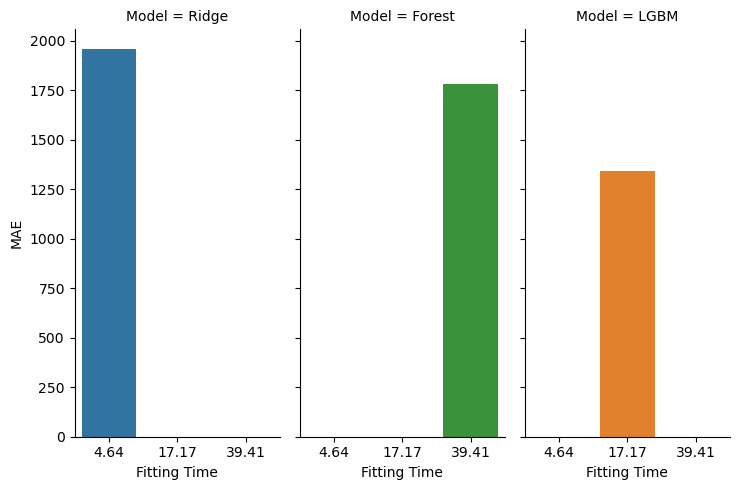

In [60]:
sns.catplot(data=results_table, x="Fitting Time", y="MAE", col="Model", kind="bar", aspect=0.5 )
plt.show()

Let's check the adequacy of the models using DummyRegressor.

### DummyRegressor

In [61]:
%%time

dummy = DummyRegressor()

dummy_fitting_time_start = time.time()
dummy.fit(features_train_scaled, target_train)
dummy_fitting_time_end = time.time()


dummy_predicting_time_start = time.time()
prediction_dummy = dummy.predict(features_test_scaled)
dummy_predicting_time_end = time.time()

dummy_RMSE = sqrt(mean_squared_error(prediction_dummy, target_test))

print(f'Dummy RMSE: {dummy_RMSE}, Fitting time: {round(dummy_fitting_time_end - dummy_fitting_time_start,2)}, Predicting time: \
{round(dummy_predicting_time_end- dummy_predicting_time_start,2)}')

Dummy RMSE: 3428.0794768494234, Fitting time: 0.01, Predicting time: 0.0
CPU times: total: 0 ns
Wall time: 10.9 ms


All models are adequate, since the accuracy of all is higher than the Dummy model.

Considering the speed and accuracy of calculations, the best model is LGBM.

### Testing the best model (LGBMRegressor)

In [62]:
lgb_an = LGBMRegressor(learning_rate = 0.3)

lgb_fitting_time = time.time()
lgb_an.fit(features_train_scaled, target_train)
lgb_fitting_time_end = time.time()

lgb_predicting_time = time.time()
lgb_prediction = lgb_an.predict(features_test_scaled)
lgb_predicting_time_end = time.time()

lgb_rmse_ = sqrt(mean_squared_error(lgb_prediction, target_test))

print(f'lgb RMSE: {lgb_rmse_}, Fitting time: {round(lgb_fitting_time_end - lgb_fitting_time,2)}, Predicting time: \
{round(lgb_predicting_time_end - lgb_predicting_time,2)}')



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 810
[LightGBM] [Info] Number of data points in the train set: 173022, number of used features: 271
[LightGBM] [Info] Start training from score 3993.744628
lgb RMSE: 1354.0516392588013, Fitting time: 1.58, Predicting time: 0.27


###  Checking feature importance

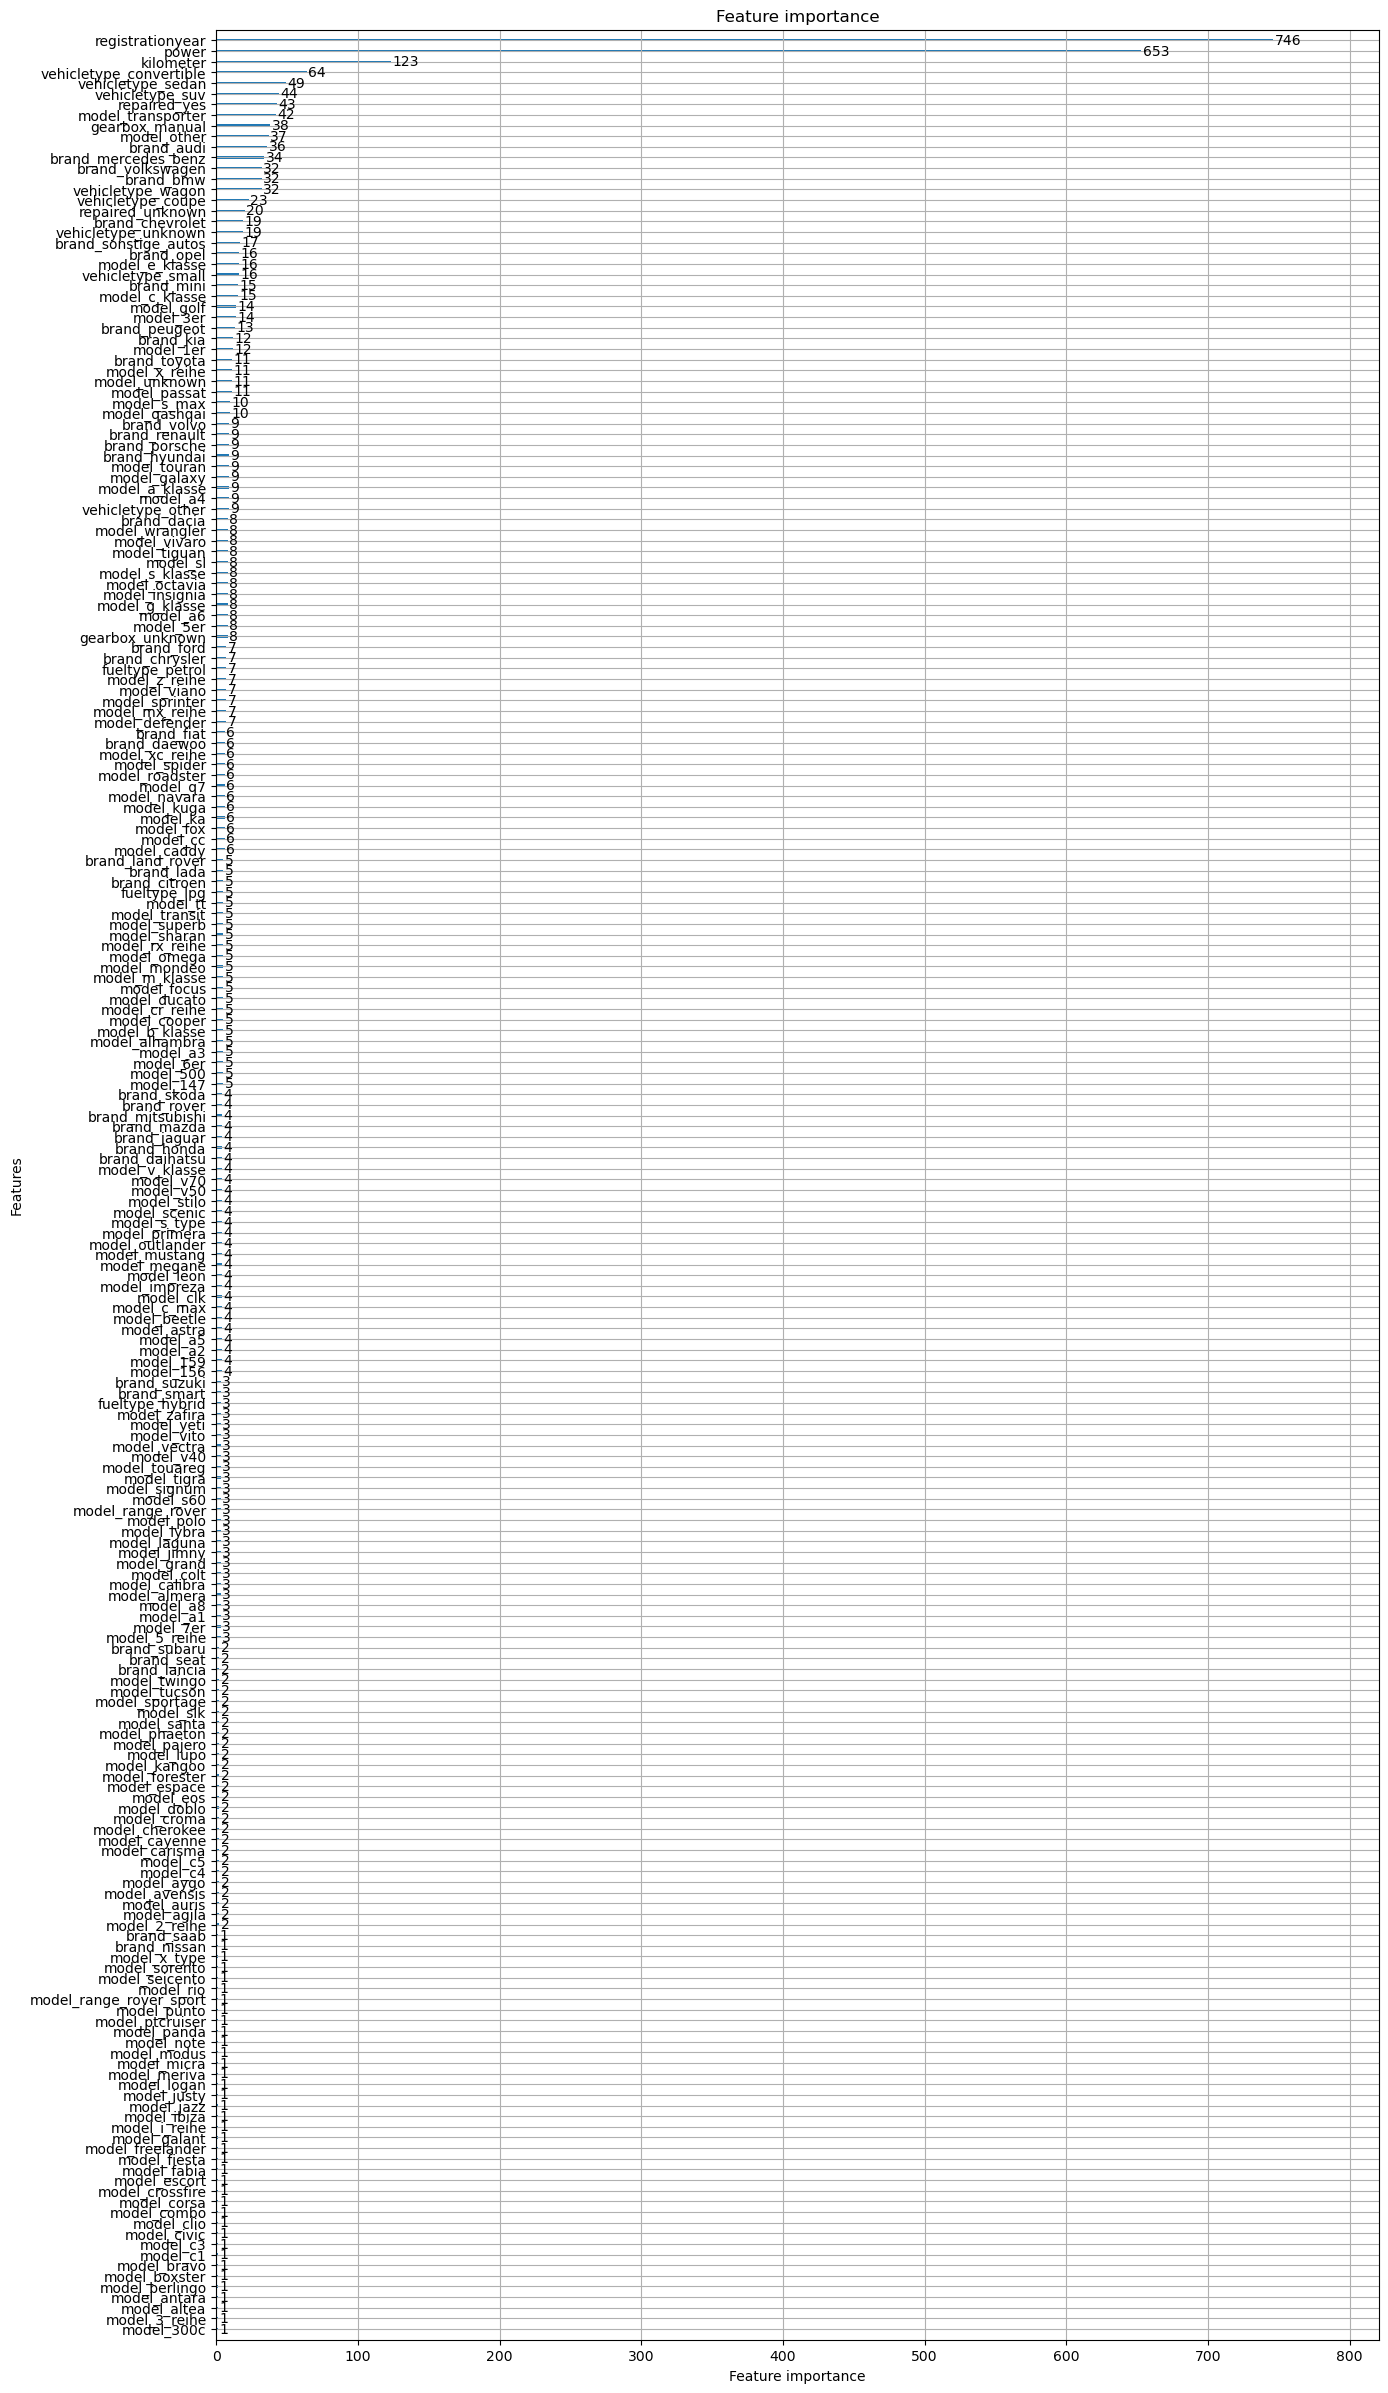

In [63]:
lightgbm.plot_importance(lgb_an, figsize = (15,30));

The factors that most influence the price of a car are, from most to least:
- 1. Registration year
- 2. Horsepower
- 3. Mileage

Let's remove the remaining features and see how the model works without them.

In [64]:
features_train_scaled = features_train_scaled[['registrationyear', 'power', 'kilometer']]
features_test_scaled = features_test_scaled[['registrationyear', 'power', 'kilometer']]


In [65]:
lgb_an = LGBMRegressor(learning_rate = 0.3)

lgb_fitting_time = time.time()
lgb_an.fit(features_train_scaled, target_train)
lgb_fitting_time_end = time.time()

lgb_predicting_time = time.time()
lgb_prediction = lgb_an.predict(features_test_scaled)
lgb_predicting_time_end = time.time()

lgb_rmse_ = sqrt(mean_squared_error(lgb_prediction, target_test))

print(f'lgb RMSE: {lgb_rmse_}, Fitting time: {round(lgb_fitting_time_end - lgb_fitting_time,2)}, Predicting time: \
{round(lgb_predicting_time_end - lgb_predicting_time,2)}')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 173022, number of used features: 3
[LightGBM] [Info] Start training from score 3993.744628
lgb RMSE: 1729.512476871836, Fitting time: 0.37, Predicting time: 0.05


RMSE has worsened by 29%, but it is still below 2500, which is the required condition. On the other hand, training and prediction speed were reduced by 92.45% and 82.60%, respectively.

## Conclusion

During the work on the project, the following tasks were carried out:

   - We analyzed the data and made the necessary adjustments.
   - We split the data into training and testing samples, digitized the categorical data, and scaled it for optimal model performance.
   - We found the optimal parameters for the Ridge Regression, RandomForestRegressor and LightGBM models and chose the model that performed best, with a RMSE of 1354, namely LightGBM.
   - Using LightGBM, we found out which features most influence the forecasts; 
   - From most to least:
             - registration year
             - power
             - mileage
   - Next, we tested the model only with these features and the results were as follows: an RMSE of 1729 (worsened by 29%), but still below 2500, which is what is required. On the other hand, training and prediction speed were reduced by 92.45% and 82.60%, respectively.

Based on this information, the most recommended model is LGBMRegressor(learning_rate = 0.3), taking into account only the features of vehicle registration year, vehicle power and mileage. However, if we are not against giving in some training speed and it is more important to increase the forecast accuracy (by 29%), then we can use the LGBMRegressor(learning_rate = 0.3) model with all the features (except for those specifically removed during the work on the project).